# Initialization

In [1]:
%matplotlib widget

# Example 1

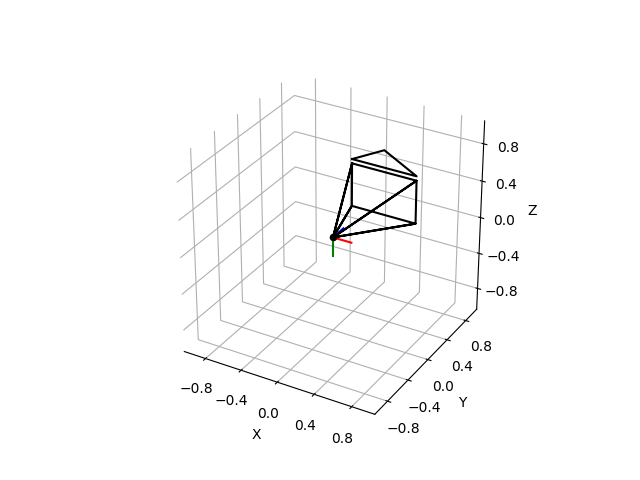

In [2]:
"""
===========================
Camera Representation in 3D
===========================

This visualization is inspired by Blender's camera visualization. It will
show the camera center, a virtual image plane at a desired distance to the
camera center, and the top direction of the virtual image plane.
"""
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt

plt.figure()
cam2world = pt.transform_from_pq([0, 0, 0, np.sqrt(0.5), -np.sqrt(0.5), 0, 0])
# default parameters of a camera in Blender
sensor_size = np.array([0.036, 0.024])
intrinsic_matrix = np.array([
    [0.05, 0, sensor_size[0] / 2.0],
    [0, 0.05, sensor_size[1] / 2.0],
    [0, 0, 1]
])
virtual_image_distance = 1

ax = pt.plot_transform(A2B=cam2world, s=0.2)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
plt.show()

# Example 2

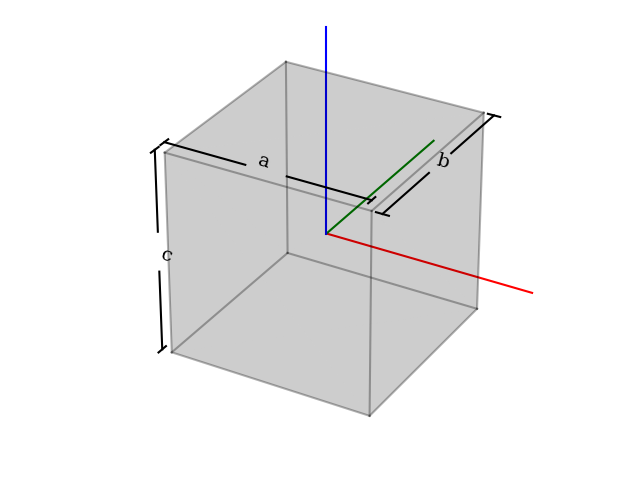

In [5]:
"""
========
Plot Box
========
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import (plot_box, plot_length_variable,
                                      remove_frame)
from pytransform3d.transformations import plot_transform


plt.figure()
ax = plot_box(size=[1, 1, 1], wireframe=False, alpha=0.1, color="k", ax_s=0.6)
plot_transform(ax=ax)
plot_box(ax=ax, size=[1, 1, 1], wireframe=True, alpha=0.3)
plot_length_variable(
    ax=ax,
    start=np.array([-0.5, -0.5, 0.55]), end=np.array([0.5, -0.5, 0.55]),
    name="a",
    fontsize=14, fontfamily="serif")
plot_length_variable(
    ax=ax,
    start=np.array([0.55, -0.5, 0.5]), end=np.array([0.55, 0.5, 0.5]),
    name="b",
    fontsize=14, fontfamily="serif")
plot_length_variable(
    ax=ax,
    start=np.array([-0.55, -0.5, -0.5]), end=np.array([-0.55, -0.5, 0.5]),
    name="c",
    fontsize=14, fontfamily="serif")
remove_frame(ax)
plt.show()

# Example 3

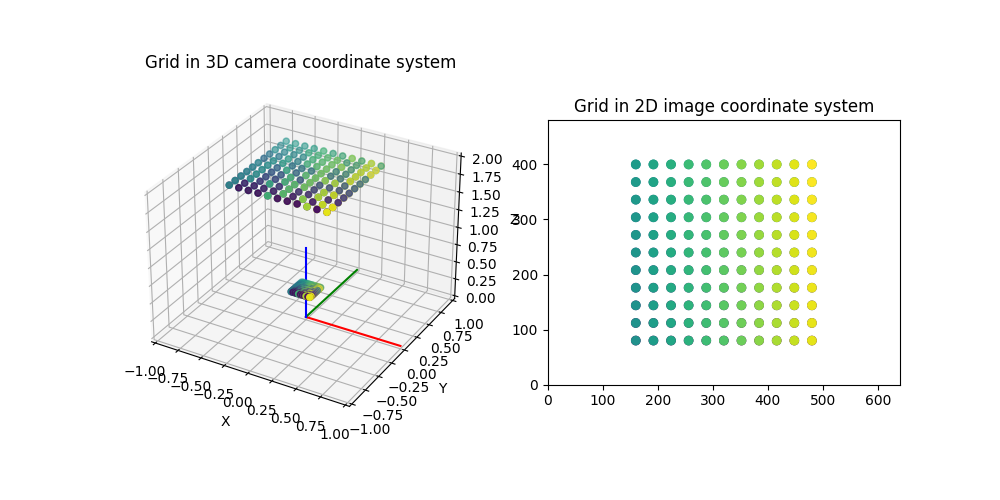

In [9]:
"""
=================
Camera Projection
=================

We can see the camera coordinate frame and a grid of points in the camera
coordinate system which will be projected on the sensor. From the coordinates
on the sensor we can compute the corresponding pixels.
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.transformations import plot_transform
from pytransform3d.camera import make_world_grid, cam2sensor, sensor2img


focal_length = 0.2
sensor_size = (0.2, 0.15)
image_size = (640, 480)

plt.figure(figsize=(10, 5))
ax = plt.subplot(121, projection="3d")
ax.set_title("Grid in 3D camera coordinate system")
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((0, 2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

cam_grid = make_world_grid(n_points_per_line=11) - np.array([0, 0, -2, 0])
img_grid = cam_grid * focal_length

c = np.arange(len(cam_grid))
ax.scatter(cam_grid[:, 0], cam_grid[:, 1], cam_grid[:, 2], c=c)
ax.scatter(img_grid[:, 0], img_grid[:, 1], img_grid[:, 2], c=c)
plot_transform(ax)

sensor_grid = cam2sensor(cam_grid, focal_length)
img_grid = sensor2img(sensor_grid, sensor_size, image_size)
ax = plt.subplot(122, aspect="equal")
ax.set_title("Grid in 2D image coordinate system")
ax.scatter(img_grid[:, 0], img_grid[:, 1], c=c)
ax.set_xlim((0, image_size[0]))
ax.set_ylim((0, image_size[1]))

plt.show()

# Example 4

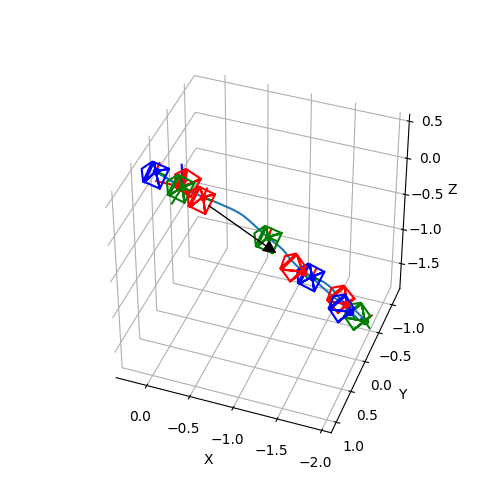

In [12]:
"""
=================
Camera Trajectory
=================

The following illustration shows a camera's trajectory that has has been
estimated from odometry. This specific trajectory has been used to reconstruct
a colored mesh from a depth camera and an RGB camera.
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.rotations as pr
import pytransform3d.camera as pc
from cycler import cycle


BASE_DIR = "test/test_data/"
data_dir = BASE_DIR
search_path = "."
while (not os.path.exists(data_dir) and
       os.path.dirname(search_path) != "pytransform3d"):
    search_path = os.path.join(search_path, "..")
    data_dir = os.path.join(search_path, BASE_DIR)

intrinsic_matrix = np.loadtxt(os.path.join(
    data_dir, "reconstruction_camera_matrix.csv"), delimiter=",")

P = np.loadtxt(os.path.join(data_dir, "reconstruction_odometry.csv"),
               delimiter=",", skiprows=1)
for t in range(len(P)):
    P[t, 3:] = pr.quaternion_wxyz_from_xyzw(P[t, 3:])
cam2world_trajectory = ptr.transforms_from_pqs(P)

plt.figure(figsize=(5, 5))
ax = pt.plot_transform(s=0.3)
ax = ptr.plot_trajectory(ax, P=P, s=0.1, n_frames=10)

image_size = np.array([1920, 1440])

key_frames_indices = np.linspace(0, len(P) - 1, 10, dtype=int)
colors = cycle("rgb")
for i, c in zip(key_frames_indices, colors):
    pc.plot_camera(ax, intrinsic_matrix, cam2world_trajectory[i],
                   sensor_size=image_size, virtual_image_distance=0.2, c=c)

pos_min = np.min(P[:, :3], axis=0)
pos_max = np.max(P[:, :3], axis=0)
center = (pos_max + pos_min) / 2.0
max_half_extent = max(pos_max - pos_min) / 2.0
ax.set_xlim((center[0] - max_half_extent, center[0] + max_half_extent))
ax.set_ylim((center[1] - max_half_extent, center[1] + max_half_extent))
ax.set_zlim((center[2] - max_half_extent, center[2] + max_half_extent))

ax.view_init(azim=110, elev=40)

plt.show()

# Example 5

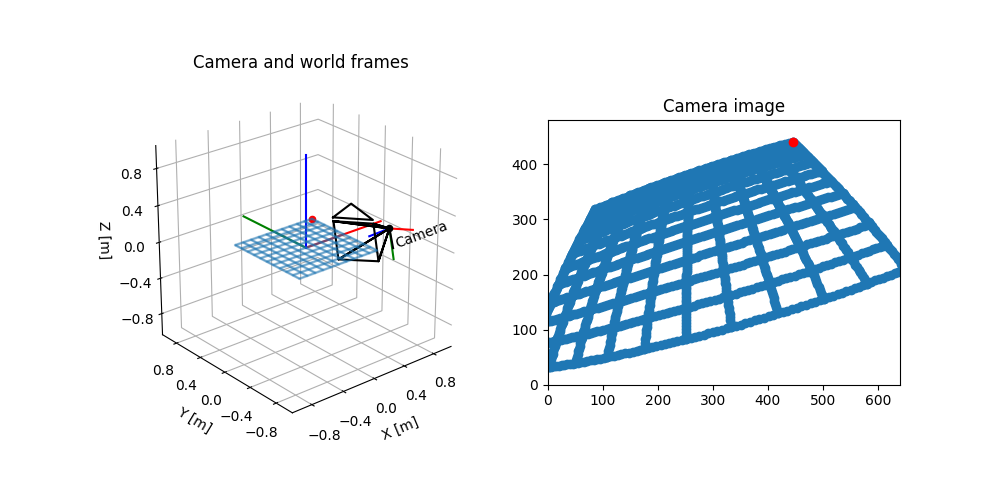

In [14]:
"""
================
Camera Transform
================

We can see the camera frame and the world frame. There is a grid of points from
which we know the world coordinates. If we know the location and orientation of
the camera in the world, we can easily compute the location of the points on
the image.
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.rotations import active_matrix_from_intrinsic_euler_xyz
from pytransform3d.transformations import transform_from, plot_transform
from pytransform3d.camera import make_world_grid, world2image, plot_camera


cam2world = transform_from(
    active_matrix_from_intrinsic_euler_xyz([-np.pi + 1, -0.1, 0.3]),
    [0.2, -1, 0.5])
focal_length = 0.0036
sensor_size = (0.00367, 0.00274)
image_size = (640, 480)
intrinsic_camera_matrix = np.array([
    [focal_length, 0, sensor_size[0] / 2],
    [0, focal_length, sensor_size[1] / 2],
    [0, 0, 1]
])

world_grid = make_world_grid(n_points_per_line=101)
image_grid = world2image(world_grid, cam2world, sensor_size, image_size,
                         focal_length, kappa=0.4)

plt.figure(figsize=(10, 5))
ax = make_3d_axis(1, 121, unit="m")
ax.view_init(elev=30, azim=-70)
plot_transform(ax)
plot_transform(ax, A2B=cam2world, s=0.3, name="Camera")
plot_camera(ax, intrinsic_camera_matrix, cam2world,
            sensor_size=sensor_size, virtual_image_distance=0.5)
ax.set_title("Camera and world frames")
ax.scatter(
    world_grid[:, 0], world_grid[:, 1], world_grid[:, 2], s=1, alpha=0.2)
ax.scatter(world_grid[-1, 0], world_grid[-1, 1], world_grid[-1, 2], color="r")
ax.view_init(elev=25, azim=-130)

ax = plt.subplot(122, aspect="equal")
ax.set_title("Camera image")
ax.set_xlim(0, image_size[0])
ax.set_ylim(0, image_size[1])
ax.scatter(image_grid[:, 0], -(image_grid[:, 1] - image_size[1]))
ax.scatter(image_grid[-1, 0], -(image_grid[-1, 1] - image_size[1]), color="r")

plt.show()

# Example 6

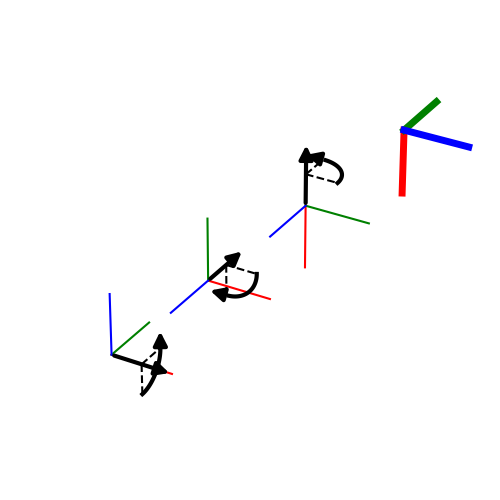

In [15]:
"""
============
Euler Angles
============

Any rotation can be represented by three consecutive rotations about three
basis vectors. Here we use the extrinsic xyz convention.
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d.plot_utils import remove_frame


alpha, beta, gamma = 0.5 * np.pi, 0.5 * np.pi, 0.5 * np.pi
p = np.array([1, 1, 1])

plt.figure(figsize=(5, 5))

ax = pr.plot_basis(R=np.eye(3), p=-1.5 * p, ax_s=2)
pr.plot_axis_angle(ax, [1, 0, 0, alpha], -1.5 * p)

pr.plot_basis(
    ax, pr.active_matrix_from_extrinsic_euler_xyz([alpha, 0, 0]), -0.5 * p)
pr.plot_axis_angle(ax, [0, 1, 0, beta], p=-0.5 * p)

pr.plot_basis(
    ax, pr.active_matrix_from_extrinsic_euler_xyz([alpha, beta, 0]), 0.5 * p)
pr.plot_axis_angle(ax, [0, 0, 1, gamma], 0.5 * p)

pr.plot_basis(
    ax,
    pr.active_matrix_from_extrinsic_euler_xyz([alpha, beta, gamma]), 1.5 * p,
    lw=5)

remove_frame(ax)

plt.show()

# Example 7

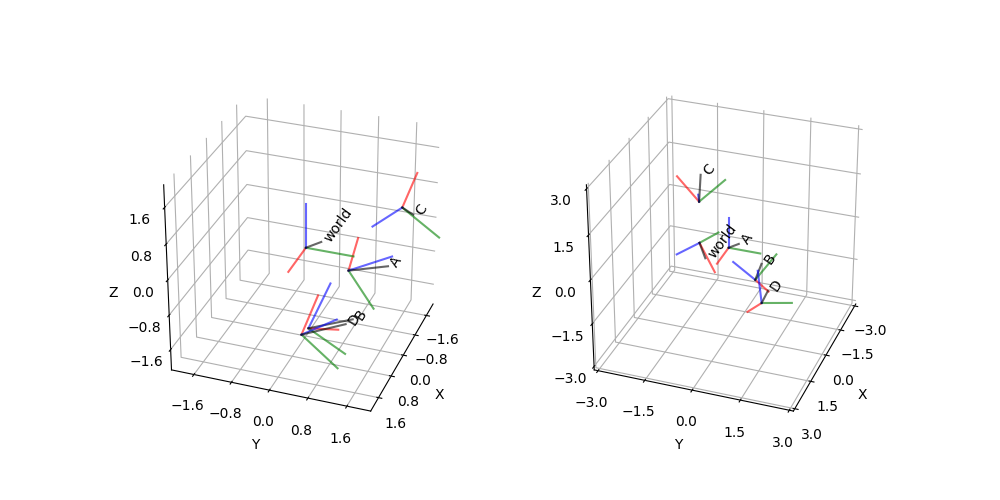

In [16]:
"""
===============================================
Plot with Respect to Different Reference Frames
===============================================

In this example, we will demonstrate how to use the TransformManager.
We will add several transforms to the manager and plot all frames in
two reference frames ('world' and 'A').
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import make_3d_axis
from pytransform3d.transformations import random_transform
from pytransform3d.transform_manager import TransformManager


rng = np.random.default_rng(5)
A2world = random_transform(rng)
B2world = random_transform(rng)
A2C = random_transform(rng)
D2B = random_transform(rng)

tm = TransformManager()
tm.add_transform("A", "world", A2world)
tm.add_transform("B", "world", B2world)
tm.add_transform("A", "C", A2C)
tm.add_transform("D", "B", D2B)

plt.figure(figsize=(10, 5))

ax = make_3d_axis(2, 121)
ax = tm.plot_frames_in("world", ax=ax, alpha=0.6)
ax.view_init(30, 20)

ax = make_3d_axis(3, 122)
ax = tm.plot_frames_in("A", ax=ax, alpha=0.6)
ax.view_init(30, 20)

plt.show()

# Example 8

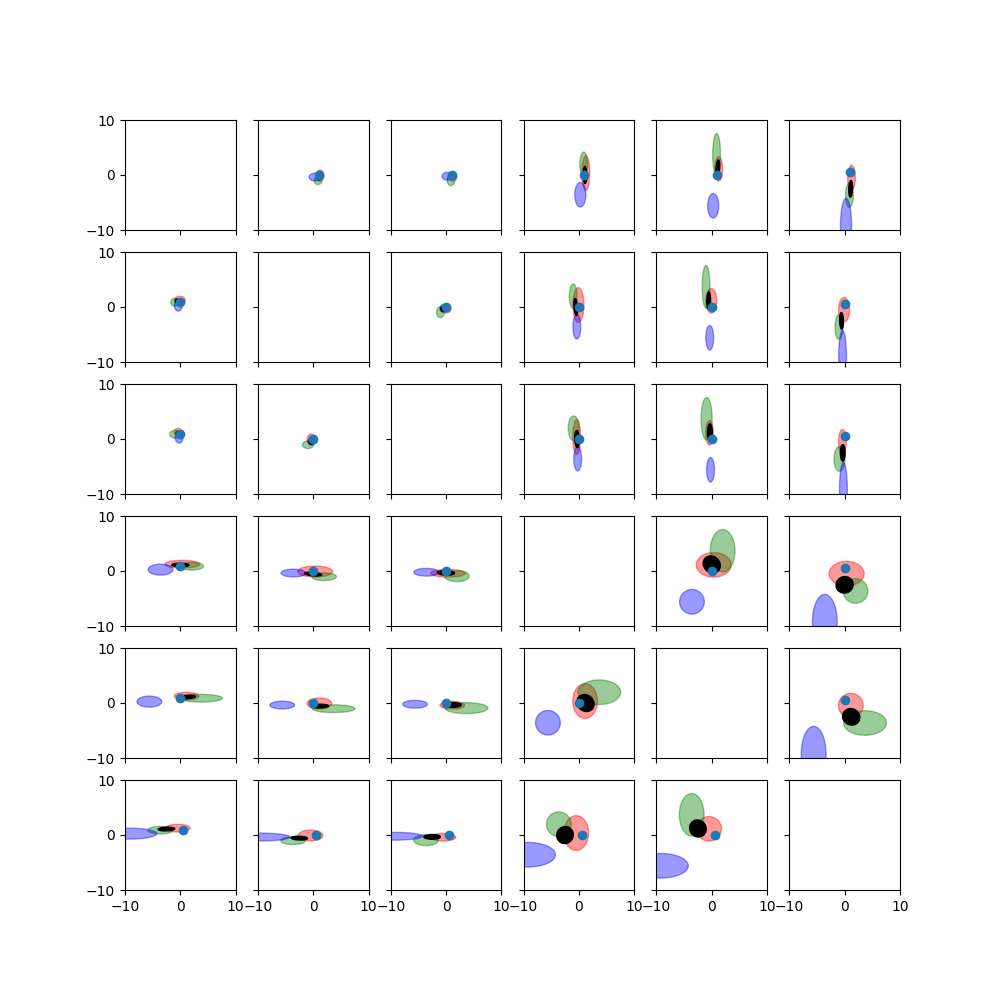

In [22]:
"""
============
Fuse 3 Poses
============

Each of the poses is has an associated covariance that is considered during
the fusion. Each of the plots shows a projection of the distributions in
exponential coordinate space to two dimensions. Red, green, and blue ellipses
represent the uncertain poses that will be fused. A black ellipse indicates
the fused pose's distribution.

This example is from

Barfoot, Furgale: Associating Uncertainty With Three-Dimensional Poses for Use
in Estimation Problems, http://ncfrn.mcgill.ca/members/pubs/barfoot_tro14.pdf
"""
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.uncertainty as pu
import pytransform3d.transformations as pt


def to_ellipse(cov, factor=1.0):
    """Compute error ellipse.

    An error ellipse shows equiprobable points of a 2D Gaussian distribution.

    Parameters
    ----------
    cov : array-like, shape (2, 2)
        Covariance of the Gaussian distribution.

    factor : float, optional (default: 1)
        One means standard deviation.

    Returns
    -------
    angle : float
        Rotation angle of the ellipse.

    width : float
        Width of the ellipse (semi axis, not diameter).

    height : float
        Height of the ellipse (semi axis, not diameter).
    """
    from scipy import linalg
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    angle = np.arctan2(*vecs[:, 0][::-1])
    width, height = factor * np.sqrt(vals)
    return angle, width, height


def plot_error_ellipse(ax, mean, cov, color=None, alpha=0.25,
                       factors=np.linspace(0.25, 2.0, 8)):
    """Plot error ellipse of MVN.

    Parameters
    ----------
    ax : axis
        Matplotlib axis.

    mean : array-like, shape (2,)
        Mean of the Gaussian distribution.

    cov : array-like, shape (2, 2)
        Covariance of the Gaussian distribution.

    color : str, optional (default: None)
        Color in which the ellipse should be plotted

    alpha : float, optional (default: 0.25)
        Alpha value for ellipse

    factors : array, optional (default: np.linspace(0.25, 2.0, 8))
        Multiples of the standard deviations that should be plotted.
    """
    from matplotlib.patches import Ellipse
    for factor in factors:
        angle, width, height = to_ellipse(cov, factor)
        ell = Ellipse(xy=mean, width=2.0 * width, height=2.0 * height,
                      angle=np.degrees(angle))
        ell.set_alpha(alpha)
        if color is not None:
            ell.set_color(color)
        ax.add_artist(ell)


x_true = np.array([1.0, 0.0, 0.0, 0.0, 0.0, np.pi / 6.0])
T_true = pt.transform_from_exponential_coordinates(x_true)
alpha = 5.0
cov1 = alpha * np.diag([0.1, 0.2, 0.1, 2.0, 1.0, 1.0])
cov2 = alpha * np.diag([0.1, 0.1, 0.2, 1.0, 3.0, 1.0])
cov3 = alpha * np.diag([0.2, 0.1, 0.1, 1.0, 1.0, 5.0])

rng = np.random.default_rng(0)

T1 = np.dot(pt.transform_from_exponential_coordinates(
    pt.random_exponential_coordinates(rng=rng, cov=cov1)), T_true)
T2 = np.dot(pt.transform_from_exponential_coordinates(
    pt.random_exponential_coordinates(rng=rng, cov=cov2)), T_true)
T3 = np.dot(pt.transform_from_exponential_coordinates(
    pt.random_exponential_coordinates(rng=rng, cov=cov3)), T_true)

x1 = pt.exponential_coordinates_from_transform(T1)
x2 = pt.exponential_coordinates_from_transform(T2)
x3 = pt.exponential_coordinates_from_transform(T3)

T_est, cov_est, V = pu.pose_fusion([T1, T2, T3], [cov1, cov2, cov3])
x_est = pt.exponential_coordinates_from_transform(T_est)

_, axes = plt.subplots(
    nrows=6, ncols=6, sharex=True, sharey=True, squeeze=True, figsize=(10, 10))
factors = [1.0]
for i in range(6):
    for j in range(6):
        if i == j:
            continue

        indices = np.array([i, j])
        ax = axes[i][j]

        for x, cov, color in zip([x1, x2, x3], [cov1, cov2, cov3], "rgb"):
            plot_error_ellipse(
                ax, x[indices], cov[indices][:, indices],
                color=color, alpha=0.4, factors=factors)

        plot_error_ellipse(
            ax, x_est[indices], cov_est[indices][:, indices],
            color="k", alpha=1, factors=factors)

        ax.scatter(x_true[i], x_true[j])

        ax.set_xlim((-10, 10))
        ax.set_ylim((-10, 10))

plt.show()

# Example 9

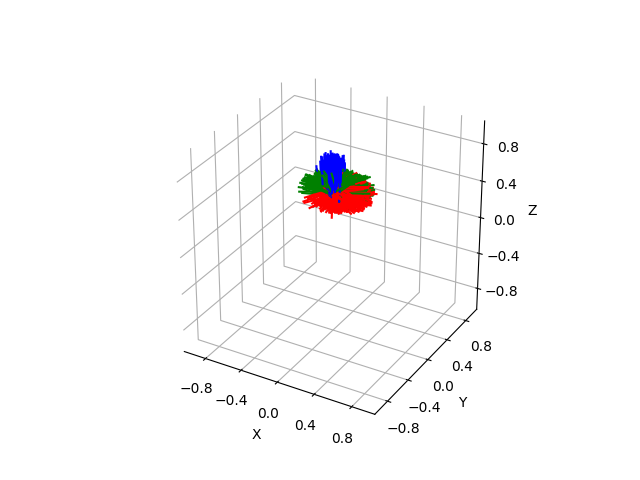

In [21]:
"""
=================
Sample Transforms
=================
"""
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt

plt.figure()
mean = pt.transform_from(R=np.eye(3), p=np.array([0.0, 0.0, 0.5]))
cov = np.diag([0.001, 0.001, 0.5, 0.001, 0.001, 0.001])
rng = np.random.default_rng(0)
ax = None
poses = np.array([
    pt.random_transform(rng=rng, mean=mean, cov=cov) for _ in range(1000)])
for pose in poses:
    ax = pt.plot_transform(ax=ax, A2B=pose, s=0.3)
plt.show()

# Example 10

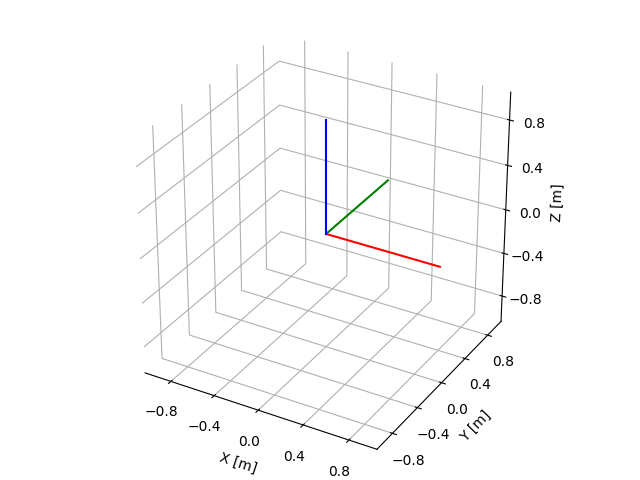

In [23]:
"""
===================
Plot Transformation
===================

We can display transformations by plotting the basis vectors of the
corresponding coordinate frame.
"""
import matplotlib.pyplot as plt
from pytransform3d.transformations import plot_transform
from pytransform3d.plot_utils import make_3d_axis

plt.figure()
ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)
plot_transform(ax=ax)
plt.tight_layout()
plt.show()

# Example 11

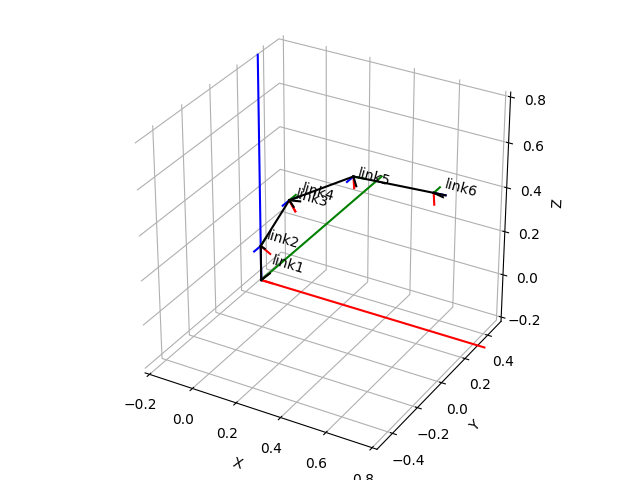

In [24]:
"""
===========
URDF Joints
===========

This example shows how to load a URDF description of a robot, set some joint
angles and display relevant frames.
"""
import matplotlib.pyplot as plt
from pytransform3d.urdf import UrdfTransformManager


# %%
# URDF
# ----
# URDFs have to be provided as strings. These can be loaded from files.
COMPI_URDF = """
<?xml version="1.0"?>
  <robot name="compi">
    <link name="linkmount"/>
    <link name="link1"/>
    <link name="link2"/>
    <link name="link3"/>
    <link name="link4"/>
    <link name="link5"/>
    <link name="link6"/>
    <link name="tcp"/>

    <joint name="joint1" type="revolute">
      <origin xyz="0 0 0" rpy="0 0 0"/>
      <parent link="linkmount"/>
      <child link="link1"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="joint2" type="revolute">
      <origin xyz="0 0 0.158" rpy="1.570796 0 0"/>
      <parent link="link1"/>
      <child link="link2"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint3" type="revolute">
      <origin xyz="0 0.28 0" rpy="0 0 0"/>
      <parent link="link2"/>
      <child link="link3"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint4" type="revolute">
      <origin xyz="0 0 0" rpy="-1.570796 0 0"/>
      <parent link="link3"/>
      <child link="link4"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="joint5" type="revolute">
      <origin xyz="0 0 0.34" rpy="1.570796 0 0"/>
      <parent link="link4"/>
      <child link="link5"/>
      <axis xyz="0 0 -1.0"/>
    </joint>

    <joint name="joint6" type="revolute">
      <origin xyz="0 0.346 0" rpy="-1.570796 0 0"/>
      <parent link="link5"/>
      <child link="link6"/>
      <axis xyz="0 0 1.0"/>
    </joint>

    <joint name="jointtcp" type="fixed">
      <origin xyz="0 0 0.05" rpy="0 0 0"/>
      <parent link="link6"/>
      <child link="tcp"/>
    </joint>
  </robot>
"""

tm = UrdfTransformManager()
tm.load_urdf(COMPI_URDF)

# %%
# Set Joints
# ----------
# In this example, we define joint angles manually. Joints are identified by
# their string names extracted from the URDF.
joint_names = ["joint%d" % i for i in range(1, 7)]
joint_angles = [0, 0.5, 0.5, 0, 0.5, 0]
for name, angle in zip(joint_names, joint_angles):
    tm.set_joint(name, angle)

# %%
# Visualization
# -------------
# We use matplotlib to visualize the link frames of the URDF and connections
# between these.
ax = tm.plot_frames_in("compi", whitelist=["link%d" % d for d in range(1, 7)],
                       s=0.05, show_name=True)
ax = tm.plot_connections_in("compi", ax=ax)
ax.set_xlim((-0.2, 0.8))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((-0.2, 0.8))
plt.show()

# Example 12

/tmp/ipykernel_29167/2877425066.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


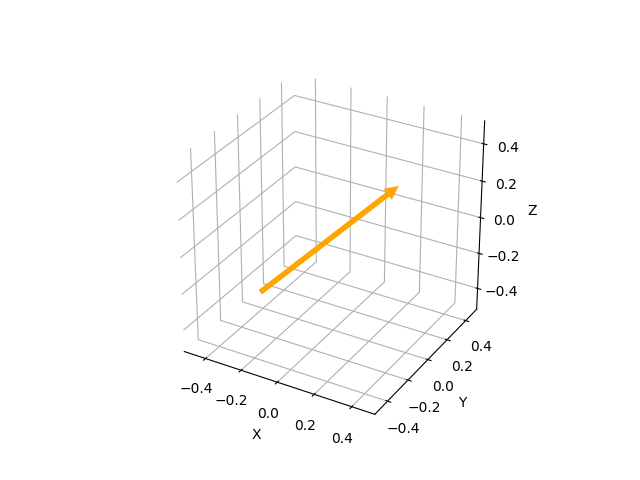

In [25]:
"""
===========
Plot Vector
===========
"""
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.plot_utils import plot_vector

plt.figure()
plot_vector(
    # A vector is defined by start, direction, and s (scaling)
    start=np.array([-0.3, -0.2, -0.3]),
    direction=np.array([1.0, 1.0, 1.0]),
    s=0.5,
    ax_s=0.5,  # Scaling of 3D axes
    lw=0,  # Remove line around arrow
    color="orange"
)
plt.show()